In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import pickle

In [ ]:
RESULTADOS_DIR = Path("Resultados/")

# --- função de feature engineering idêntica à do Script 5 ---
def build_features(df):
    df = df.copy()
    # filtros prévios já aplicados antes de chamar esta função
    df["startYear"] = pd.to_numeric(df["startYear"], errors="coerce").fillna(-1).astype(int)
    df["runtimeMinutes"] = pd.to_numeric(df["runtimeMinutes"], errors="coerce").fillna(-1)
    df["averageRating"] = pd.to_numeric(df["averageRating"], errors="coerce").fillna(-1)
    df["numVotes"] = pd.to_numeric(df["numVotes"], errors="coerce").fillna(0)
    df["genres"] = df["genres"].fillna("Unknown")
    df["idade_titulo"] = (2025 - df["startYear"]).clip(lower=0)

    # gêneros -> k-1 dummies
    df["genres"] = df["genres"].apply(lambda x: x if isinstance(x, list) else str(x).split(","))
    df_e = df.explode("genres")
    df_e["genres"] = df_e["genres"].str.strip()
    gen_dum = pd.get_dummies(df_e["genres"], prefix="genre", drop_first=True)
    gen_dum = gen_dum.groupby(df_e.index).max()
    df = pd.concat([df, gen_dum], axis=1)

    # tipo -> k-1 dummies
    df = pd.get_dummies(df, columns=["titleType"], prefix="type", drop_first=True)

    # normaliza match_score 0–1 se existir
    if "match_score" in df.columns:
        df["match_score"] = pd.to_numeric(df["match_score"], errors="coerce").fillna(0)
        df.loc[df["match_score"] > 1, "match_score"] = df.loc[df["match_score"] > 1, "match_score"]/100.0

    return df

In [5]:
# --- carregar bases ---
train_raw = pd.read_parquet(RESULTADOS_DIR / "Base_Modelagem.parquet", engine="fastparquet")
catalog_raw = pd.read_parquet(RESULTADOS_DIR / "Catalogo_IMDB_Unido.parquet", engine="fastparquet")

In [6]:
# --- filtros: só match perfeito, nota válida ---
def only_valid_movies(df):
    return df[(df["match_score"] == 1.0) & (df["averageRating"] != -1)].copy()

train = only_valid_movies(train_raw)
catalog_raw = only_valid_movies(catalog_raw)

In [7]:
# garantir coluna alvo no catálogo (negativos)
if "assistido" not in catalog_raw.columns:
    catalog_raw["assistido"] = 0

print(f"Treino (após filtros): {len(train_raw):,}")
print(f"Catálogo (após filtros): {len(catalog_raw):,}")

Treino (após filtros): 654
Catálogo (após filtros): 7,410


In [8]:
# --- aplicar feature engineering consistente ---
catalog_feat = build_features(catalog_raw)

In [9]:
# --- definir X e y do treino (remover colunas textuais) ---
drop_cols = ["assistido","netflix_title","imdb_title","genres"]  # algumas podem não existir no catálogo
X_cols = [c for c in train.columns if c not in drop_cols]
X_train_full = train[X_cols].copy()
y_train_full = train["assistido"].astype(int)

In [10]:
# --- (importante) alinhar catálogo às colunas de treino ---
catalog_feat_aligned = catalog_feat.reindex(columns=X_cols, fill_value=0)

In [11]:
# --- checar variabilidade do alvo (precisa de 0 e 1) ---
if y_train_full.nunique() < 2:
    # criar negativos a partir do catálogo (balanceado) para permitir treino
    neg = catalog_feat_aligned.copy()
    neg["assistido"] = 0
    pos = train[X_cols + ["assistido"]].copy()
    pos["assistido"] = 1
    # balancear por min(len(pos), len(neg))
    m = min(len(pos), len(neg))
    df_bal = pd.concat([pos.sample(n=m, random_state=42), neg.sample(n=m, random_state=42)], ignore_index=True)
    X = df_bal[X_cols]
    y = df_bal["assistido"].astype(int)
else:
    X = X_train_full
    y = y_train_full

In [12]:
# --- split, treino, avaliação ---
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = XGBClassifier(
    n_estimators=400, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42, use_label_encoder=False, eval_metric="logloss"
)
model.fit(X_tr, y_tr)

y_va_p = model.predict_proba(X_va)[:,1]
print(f"AUC validação: {roc_auc_score(y_va, y_va_p):.3f}")
print(classification_report(y_va, (y_va_p>=0.5).astype(int)))

c:\Users\arviz\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:21:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUC validação: 0.822
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       125
           1       0.74      0.74      0.74       124

    accuracy                           0.74       249
   macro avg       0.74      0.74      0.74       249
weighted avg       0.74      0.74      0.74       249




📊 Calculando importância das variáveis...

Top 15 variáveis mais importantes:
type_tvSeries        1.000
genre_Reality-TV     0.270
genre_Sci-Fi         0.193
genre_Comedy         0.189
genre_Thriller       0.162
genre_Documentary    0.161
numVotes             0.135
genre_Horror         0.129
genre_Biography      0.117
genre_Romance        0.111
genre_Animation      0.107
startYear            0.105
runtimeMinutes       0.104
genre_Mystery        0.100
genre_Family         0.100
dtype: float32


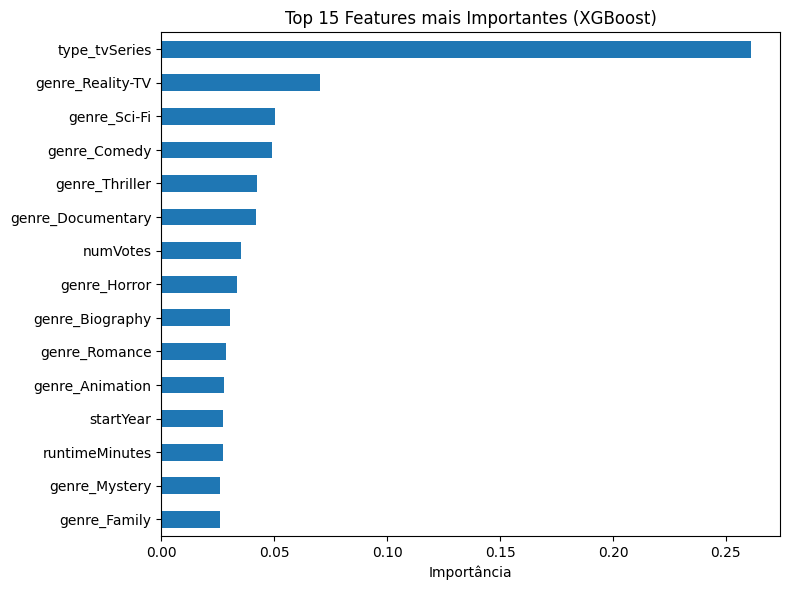

💾 Importâncias salvas em: Resultados\Importancia_Features_Modelo.csv


In [13]:
# -------------------------------------------------------------
# 🔍 Importância das variáveis (explicabilidade)
# -------------------------------------------------------------
print("\n📊 Calculando importância das variáveis...\n")

# Cria série ordenada
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Normaliza (0–1) para facilitar interpretação
importances_norm = (importances / importances.max()).round(3)

# Exibe top 15 no console
print("Top 15 variáveis mais importantes:")
print(importances_norm.head(15))

# Gráfico
plt.figure(figsize=(8, 6))
importances.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 Features mais Importantes (XGBoost)")
plt.xlabel("Importância")
plt.tight_layout()
plt.show()

# Salvar tabela completa de importância
imp_path = RESULTADOS_DIR / "Importancia_Features_Modelo.csv"
importances_norm.to_csv(imp_path, sep=";", decimal=",", encoding="utf-8-sig")

print(f"💾 Importâncias salvas em: {imp_path}")


In [14]:
# --- aplicar no catálogo (já alinhado) ---
catalog_probs = model.predict_proba(catalog_feat_aligned)[:,1]
catalog_out = catalog_raw.copy()
catalog_out["prob_assistir"] = catalog_probs

In [15]:
# salvar
catalog_out.sort_values("prob_assistir", ascending=False).to_csv(
    RESULTADOS_DIR / "Recomendacoes_Catalogo_MatchPerfeito.csv",
    sep=";", decimal=",", index=False, encoding="utf-8-sig"
)

In [16]:
modelo_path = RESULTADOS_DIR / "Modelo_XGBoost_MatchPerfeito.pkl"

with open(modelo_path, "wb") as f:
    pickle.dump(model, f)

print(f"\n✅ Modelo XGBoost salvo com sucesso em: {modelo_path}")


✅ Modelo XGBoost salvo com sucesso em: Resultados\Modelo_XGBoost_MatchPerfeito.pkl
